In [1]:
# library stuff
# Install
#!pip install mne
#!pip install pandas
#!pip install numpy

# Importing libraries
import mne
import pandas as pd
import numpy as np
from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap
from datetime import datetime, timezone, timedelta
import pytz
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

In [2]:
def preprocessing(path_EEG_CSV, path_PsychoPy_log, path_PsychoPy_CSV, participantName, consider_certainty=True, certainty_threshold=0.5):
	
	# Helper functions to convert from UNIX time to UTC time
	# UNIX time is saved as an integer (seconds since 1/1/1970)
	# UTC time is saved as a string ("YYYY-MM-DDTHH:MM:SSZ")
	def unix_to_utc(unix_timestamp):
		utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
		local_timezone = pytz.timezone('America/Los_Angeles')
		local_time = utc_time.astimezone(local_timezone) # This gives our UTC time converted to PST
		return utc_time # This gives our raw UTC time
	def utc_to_unix(utc_time_str):
		utc_time = datetime.strptime(utc_time_str, "%Y-%m-%dT%H:%M:%SZ")
		utc_time = utc_time.replace(tzinfo=timezone.utc)
		unix_timestamp = int(utc_time.timestamp())
		return unix_timestamp
	
	# Function to load the data. Simply enter a file path
	def load_eeg_data(file_path):

		# Create a dataframe from our data, replace NAs with 0s
		df = pd.read_csv(file_path, sep='\t', skiprows=2, header=None)
		df.fillna(0.0, inplace=True)

		# Extract EEG data
		trial_data = df.iloc[:, 1:24].values

		# Declares channel names and types of each set of data
		sfreq = 255  # sample rate in Hz
		ch_names = ['Channel {}'.format(i+1) for i in range(trial_data.shape[1])]
		ch_types = ['eeg' for i in range(trial_data.shape[1])]

		# Get the measurement date
		start_time_unix = trial_data[0][21] # This is where EEG start time is stored in UNIX time
		meas_date = unix_to_utc(start_time_unix) # However, MNE takes UTC time

		# Create info structures and RawArray objects for each set of data
		info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
		info.set_meas_date(meas_date)
		raw = mne.io.RawArray(trial_data.T, info)

		# Removing irrelevant channels
		ch_names = [raw.ch_names]
		ch_names_to_keep = [ch_names[0][0:8]]
		raw = raw.pick(ch_names_to_keep[0])

		# Return the RawArray object
		return raw
	
	# Helper function, converts PsychoPy's timestamp into UNIX
	def psychopy_to_unix(psychopy_time):
		
		# Define the format of the input timestamp
		format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

		# Parse the custom timestamp into a datetime object
		parsed_timestamp = datetime.strptime(psychopy_time, format_string)

		# Convert the datetime object to a Unix timestamp (floating-point for microseconds)
		unix_timestamp = parsed_timestamp.timestamp()

		# Print the Unix timestamp
		return unix_timestamp

	# Function to load psychopy data. Simply input the file path
	def load_psychopy_data(file_path):

		# Read psychopy data into a pandas dataframe
		psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)
		
		#create a new column for the unix time of psychopy stimuli
		psychopy_df = psychopy_df.dropna(subset=["expStart"])
		psychopy_df["expStart"] = psychopy_df["expStart"].astype(str)
		psychopy_df["unix_time"] = psychopy_df["expStart"].apply(psychopy_to_unix)
		
		return psychopy_df
	
	# Function to load log data
	def load_log_data(file_path):
		log_df = pd.read_csv(file_path, sep="\t", header=None, encoding="utf-8")
		log_df = log_df.rename(columns={0: "time", 1: "type", 2: "action"}) # Renames columns for easier access
		return log_df
	
	action_practice_training = ["practice_amharicc: autoDraw = True",
							"amharic_practice2: autoDraw = True"]
	action_practice_testing = ["textAmharic_9: autoDraw = True"]
	action_correctness = ["textCheck: text = '✓'", 
						"textXmark: text = '✗'"]
	action_training = ["amharics1: autoDraw = True", 
						"amharics1_2: autoDraw = True", 
						"amharics2: autoDraw = True", 
						"amharics2_2: autoDraw = True", 
						"amharics3: autoDraw = True", 
						"amharics3_2: autoDraw = True", 
						"amharics4: autoDraw = True", 
						"amharics4_2"]
	action_testing = ["textAmharic_5: autoDraw = True", 
					"textAmharic_6: autoDraw = True", 
					"textAmharic_7: autoDraw = True", 
					"textAmharic_8: autoDraw = True"]
	action_english = ["textOptionA_5: autoDraw = True",
					"textOptionB_5: autoDraw = True",
					"textOptionC_5: autoDraw = True",
					"textOptionD_5: autoDraw = True",
					"textOptionA_6: autoDraw = True",
					"textOptionB_6: autoDraw = True",
					"textOptionC_6: autoDraw = True",
					"textOptionD_6: autoDraw = True",
					"textOptionA_7: autoDraw = True",
					"textOptionB_7: autoDraw = True",
					"textOptionC_7: autoDraw = True",
					"textOptionD_7: autoDraw = True",
					"textOptionA_8: autoDraw = True",
					"textOptionB_8: autoDraw = True",
					"textOptionC_8: autoDraw = True",
					"textOptionD_8: autoDraw = True"]
	action_keypress = ["Keypress: left",
					"Keypress: right",
					"Keypress: up",
					"Keypress: down",
					"Keypress: space"]
	action_diamond = ["textDiamond_8: autoDraw = True", 
					"textDiamond_3: autoDraw = True", 
					"textDiamond_5: autoDraw = True",
					"textDiamond_6: autoDraw = True",
					"textDiamond_7: autoDraw = True",]

	raw = load_eeg_data(path_EEG_CSV)
	psychopy_df = load_psychopy_data(path_PsychoPy_CSV)
	log_df = load_log_data(path_PsychoPy_log)

	filtered_actions = action_testing + action_correctness
	pattern = "|".join(filtered_actions)
	sub_df = log_df[log_df["action"].str.contains(pattern, na=False, regex=True)]
	sub_df.index = range(len(sub_df)) # Renaming row indices for easier iteration

	filtered_certainty = action_keypress + action_diamond + action_practice_testing + action_testing + action_correctness
	certainty_pattern = "|".join(filtered_certainty)
	certainty_df = log_df[log_df["action"].str.contains(certainty_pattern, na=False, regex=True)]
	certainty_df.index = range(len(certainty_df)) # Renaming row indices for easier iteration

	certainty_timestamps = []
	for index in range(len(certainty_df)): # Certainty timestamps
		if ("textAmharic" in certainty_df["action"][index]): 
			certainty = float(certainty_df["time"][index+2] - certainty_df["time"][index+1])
			if certainty < certainty_threshold:
				timestamp, correctness = float(certainty_df["time"][index]), certainty_df["action"][index+3][-2]
				certainty_timestamps.append((timestamp, correctness))
		
	def extract_rows(df, check_symbol, pattern):
		"""
		Extract rows where the 'action' contains 'textAmharic' and the next row's 'action'
		contains the specified check symbol.
		
		Parameters:
			df (pd.DataFrame): The DataFrame containing the data.
			check_symbol (str): The symbol to look for in the next row's action.
			
		Returns:
			learned_list (list): List of rows (as pd.Series) that meet the criteria.
		"""
		list = []
		check_symbol_exists = (check_symbol != "")
		
		# Loop through all rows
		for i in range(len(df)):
			current_action = df.iloc[i]["action"]
			if (check_symbol_exists) and (i < len(df) - 1):
				next_action = df.iloc[i + 1]["action"]
				if str(pattern) in current_action and check_symbol in next_action:
					list.append(df.iloc[i]["time"])
			else:
				if str(pattern) in current_action:
					list.append(df.iloc[i]["time"])
		return list


	learned_list = extract_rows(sub_df, check_symbol="✓", pattern="textAmharic")
	not_learned_list = extract_rows(sub_df, check_symbol="✗", pattern="textAmharic")

	# lists are a bunch of np.float64, convert these all to standard floats
	def np_float_to_float(np_float64_list):
		new_list = []

		for i in range(0,len(np_float64_list)):
			new_list.append(float(np_float64_list[i]))
		
		return new_list


	# now we have lists of just the times
	learned_list_times = np_float_to_float(learned_list)
	not_learned_list_times = np_float_to_float(not_learned_list)
	certainty_list_times = []
	for timestamp, correctness in certainty_timestamps:
		if (correctness == "✓"): 
			certainty_list_times.append(timestamp)

	duration = 1
	if (consider_certainty):
		length = len(certainty_list_times) + len(not_learned_list_times) 
		not_learned_tags = ["not_learned"] * len(not_learned_list_times)
		certainty_tags = ["certainly_learned"] * len(certainty_list_times)
		final_onsets = certainty_list_times + not_learned_list_times
		final_description = certainty_tags + not_learned_tags
	else:
		length = len(learned_list_times) + len(not_learned_list_times)
		not_learned_tags = ["not_learned"] * len(not_learned_list_times)
		learned_tags = ["learned"] * len(learned_list_times)
		final_onsets = learned_list_times + not_learned_list_times
		final_description = learned_tags + not_learned_tags
	duration_list = [duration] * length

	buffer = psychopy_df.loc[0, 'unix_time'] - utc_to_unix(raw.info['meas_date'].strftime("%Y-%m-%dT%H:%M:%SZ"))
	new_orig_time = (raw.info['meas_date'] + timedelta(seconds=buffer)).strftime("%Y-%m-%d %H:%M:%S.%f")

	later_annot = mne.Annotations(
		onset = final_onsets,
		duration = duration_list,
		description = final_description,
		orig_time=new_orig_time,
	)

	raw = raw.copy().set_annotations(later_annot)
	#raw.compute_psd(fmin=0,fmax=50).plot()
	f_low = 0.1
	f_high = 30
	data_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
	#low and high pass filter, fir_design can be changed to match what lit review did

	#notch filter for electrical noise
	data_cleaned.notch_filter(60)
	picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  

	ica = ICA(n_components=8, random_state=97, method="fastica")

	ica.fit(raw)   
	#raw cleaned has been through filtering
	#clean will have gone through ica

	data_cleaned = ica.apply(raw)

	# Extract events from annotations
	events, event_id = mne.events_from_annotations(data_cleaned)

	# Define the epoch time window (start and end in seconds relative to event onset)
	tmin, tmax = -0.2, 1  # for example, 200ms before and 500ms after each event

	#mne expects event ID to be ints and not strings, so we need to change our annotations via dictionary

	# Create epochs
	if (consider_certainty):
		event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"certainly_learned": 1, "not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
		

		# make different epochs for each label
		certainly_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"certainly_learned": 1},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)

		not_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
	else: 
		event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"learned": 1, "not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
		

		# make different epochs for each label
		learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"learned": 1},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)

		not_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=None,               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)



	# VISUALIZATION
	# evoked_dict = {event: event_epochs[event].average() for event in event_id}
	# certainly_evoked = certainly_learned_event_epochs.average()
	# not_learned_evoked = not_learned_event_epochs.average()
	# evoked_dict = {"certainly_learned": certainly_evoked, "not_learned": not_learned_evoked}
	# mne.viz.plot_compare_evokeds(evoked_dict, picks='eeg', title='ERP Comparison')



	# Step 1: Get epoch data
	X_epochs = event_epochs.get_data()
	#print(f"Original shape: {X_epochs.shape}")  # Shape: (epochs, channels, times) times is the amount of samples. 

	# repeat for the other epochs
	if (consider_certainty):
		certainly_learned_epochs = certainly_learned_event_epochs.get_data()
		#print(f"Original shape: {certainly_learned_epochs.shape}")
	else:
		learned_epochs = learned_event_epochs.get_data()
		#print(f"Original shape: {learned_epochs.shape}")


	not_learned_epochs = not_learned_event_epochs.get_data()
	#(f"Original shape: {not_learned_epochs.shape}")
	# Step 2: Apply PCA
	n_components = 8
	pca_mne = UnsupervisedSpatialFilter(PCA(n_components=n_components), average=False)
	X_pca = pca_mne.fit_transform(X_epochs)
	#print(f"After PCA shape: {X_pca.shape}")  # Shape: (epochs, components, times)

	# repeat
	if (consider_certainty):
		certainly_learned_pca = pca_mne.fit_transform(certainly_learned_epochs)
		#print(f"After PCA shape: {certainly_learned_pca.shape}")
	else:
		learned_pca = pca_mne.fit_transform(learned_epochs)
		#print(f"After PCA shape: {learned_pca.shape}")

	not_learned_pca = pca_mne.fit_transform(not_learned_epochs)
	#print(f"After PCA shape: {not_learned_pca.shape}")
	# Step 3: Reshape data for machine learning
	X_flat = X_pca.reshape(X_pca.shape[0], -1)  # Shape: (epochs, components * times)
	#print(f"Flattened shape: {X_flat.shape}")
	#print(X_flat)

	if (consider_certainty):
		certainly_learned_flat = certainly_learned_pca.reshape(certainly_learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
		#print(f"Flattened shape: {certainly_learned_flat.shape}")
		#print(certainly_learned_flat)
	else:
		learned_flat = learned_pca.reshape(learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
		#print(f"Flattened shape: {learned_flat.shape}")
		#print(learned_flat)

	not_learned_flat = not_learned_pca.reshape(not_learned_pca.shape[0], -1)  # Shape: (epochs, components * times)
	#print(f"Flattened shape: {not_learned_flat.shape}")
	#print(not_learned_flat)

	# write to a csv
	np.savetxt('../processed_EEG_data/' + participantName + '.csv',X_flat, delimiter=',', fmt='%f')
	np.savetxt('../clean_learned_EEG/clean_learned_' + participantName + '.csv', certainly_learned_flat, delimiter=',', fmt='%f')
	np.savetxt('../clean_not_learned_EEG/clean_notLearned_' + participantName + '.csv',not_learned_flat, delimiter=',', fmt='%f')

# Store our EEG data path in a variable

# Aaron's relative file paths

# Josh Irby
irby_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_9_2025_JoshIrby_OpenBCI/OpenBCISession_2025-03-09_14-39-02/BrainFlow-RAW_2025-03-09_14-39-02_0.csv'
irby_psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.csv'
irby_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.log'

# Sarah
sarah_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_9_2025_Sarah_OpenBCI/OpenBCISession_2025-03-09_13-24-49/BrainFlow-RAW_2025-03-09_13-24-49_0.csv'
sarah_psyhcopy_file_path_csv ='../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_Sarah_PsychoPy/138512_finaltest_2025-03-09_13h31.15.766.csv'
sarah_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_Sarah_PsychoPy/138512_finaltest_2025-03-09_13h31.15.766.log'

# Devin
devin_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_11_2025_Devin_OpenBCI/OpenBCISession_2025-03-11_17-07-21/BrainFlow-RAW_2025-03-11_17-07-21_1.csv'
devin_psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_11_2025_Devin_PsychoPy/devin_finaltest_2025-03-11_17h30.44.028.csv'
devin_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_11_2025_Devin_PsychoPy/devin_finaltest_2025-03-11_17h30.44.028.log'

# Chengyi
chengyi_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_12_2025_Chengyi_OpenBCI/OpenBCISession_2025-03-12_17-07-49/BrainFlow-RAW_2025-03-12_17-07-49_1.csv'
chengyi_psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_12_2025_Chengyi_PsychoPy/69_finaltest_2025-03-12_17h33.18.370.csv'
chengyi_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_12_2025_Chengyi_PsychoPy/69_finaltest_2025-03-12_17h33.18.370.log'

# Afnaan
afnaan_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_13_2025_Afnaan_OpenBCI/OpenBCISession_2025-03-13_22-03-16/BrainFlow-RAW_2025-03-13_22-03-16_0.csv'
afnaan_psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_13_2025_Afnaan_PsychoPy/69000_finaltest_2025-03-13_22h43.00.897.csv'
afnaan_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_13_2025_Afnaan_PsychoPy/69000_finaltest_2025-03-13_22h43.00.897.log'

# Joshua Wei
wei_eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_13_2025_JoshuaWei_OpenBCI/OpenBCISession_2025-03-13_19-40-36/BrainFlow-RAW_2025-03-13_19-40-36_0.csv'
wei_psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.csv'
wei_log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.log'


# Chengyi's files
# eeg_file_path_csv = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_13_2025_JoshuaWei_OpenBCI/OpenBCISession_2025-03-13_19-40-36/BrainFlow-RAW_2025-03-13_19-40-36_0.csv'
# psyhcopy_file_path_csv = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)\PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.csv'
# log_path = 'C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.log'


# writing them seperately for now to isolate any bad files
preprocessing(wei_eeg_file_path_csv, wei_log_path, wei_psyhcopy_file_path_csv, "JoshuaWei")
preprocessing(irby_eeg_file_path_csv, irby_log_path, irby_psyhcopy_file_path_csv, "Irby")
preprocessing(sarah_eeg_file_path_csv, sarah_log_path, sarah_psyhcopy_file_path_csv, "Sarah")
preprocessing(devin_eeg_file_path_csv, devin_log_path, devin_psyhcopy_file_path_csv, "Devin")
preprocessing(chengyi_eeg_file_path_csv, chengyi_log_path, chengyi_psyhcopy_file_path_csv, "Chengyi")
preprocessing(afnaan_eeg_file_path_csv, afnaan_log_path, afnaan_psyhcopy_file_path_csv, "Afnaan")

FileNotFoundError: [Errno 2] No such file or directory: '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_13_2025_JoshuaWei_OpenBCI/OpenBCISession_2025-03-13_19-40-36/BrainFlow-RAW_2025-03-13_19-40-36_0.csv'

In [3]:
#Combine CSV files into one function

import glob
import os

def combine_csv_into_one(directory_path):
    
    pattern = os.path.join(directory_path, "clean*.csv")
    csv_files = glob.glob(pattern)

    all_dfs = []
    for file in csv_files:
        df = pd.read_csv(file, header = None)
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

learned_path = "../clean_learned_EEG"
not_learned_path = "../clean_not_learned_EEG"

learned_df = combine_csv_into_one(learned_path)
not_learned_df = combine_csv_into_one(not_learned_path)

learned_output_path = os.path.join(learned_path, "combined_learned.csv")
learned_df.to_csv(learned_output_path, index=False)

not_learned_output_path = os.path.join(not_learned_path, "combined_not_learned.csv")
not_learned_df.to_csv(not_learned_output_path, index=False)

Creating RawArray with float64 data, n_channels=23, n_times=749956
    Range : 0 ... 749955 =      0.000 ...  2941.000 secs
Ready.


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,31,40,46,57,58,223,282,316,329,346,360,376,393,403,416,433,443,454,488,495,503,504) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

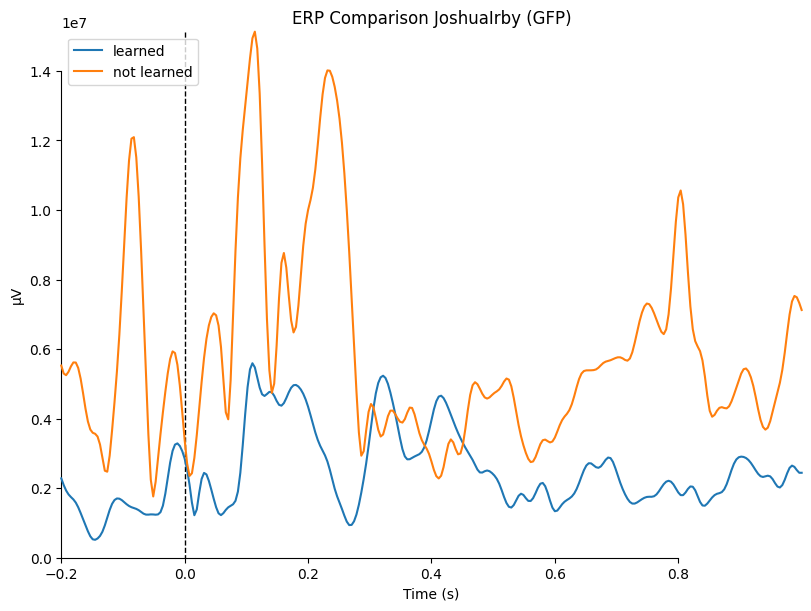

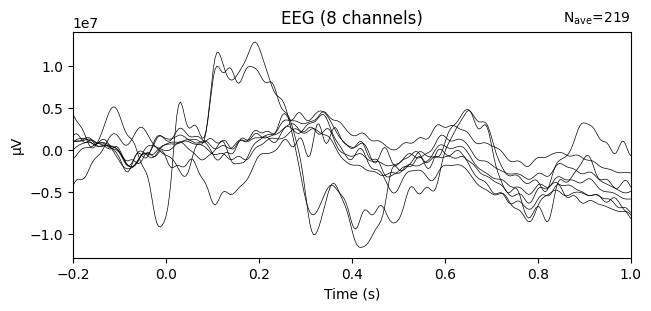

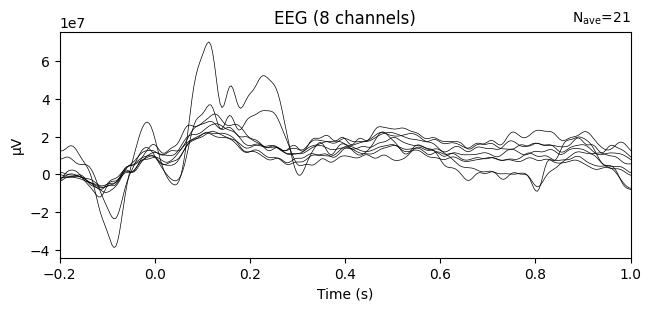

Creating RawArray with float64 data, n_channels=23, n_times=723402
    Range : 0 ... 723401 =      0.000 ...  2836.867 secs
Ready.


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,23,33,37,44,50,61,62,227,286,290,322,333,350,354,366,376,385,402,411,428,445,455,466,501,508,516,517) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

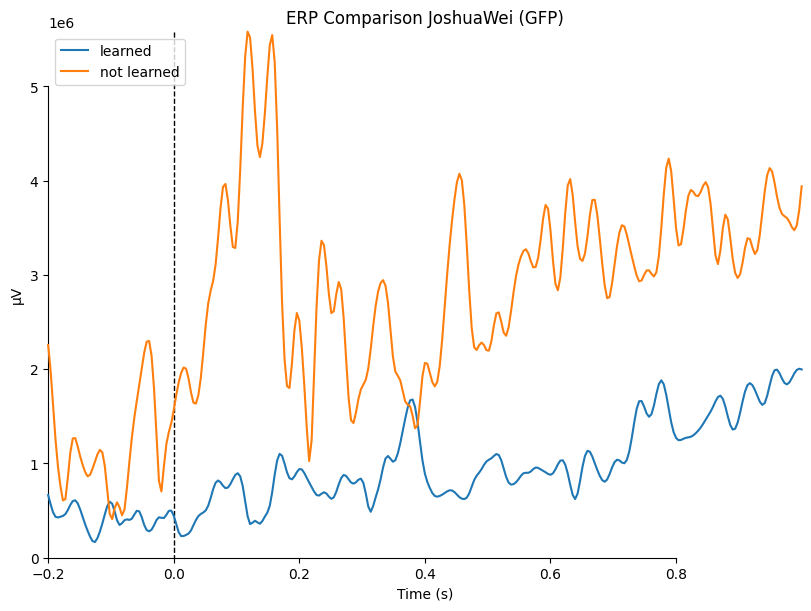

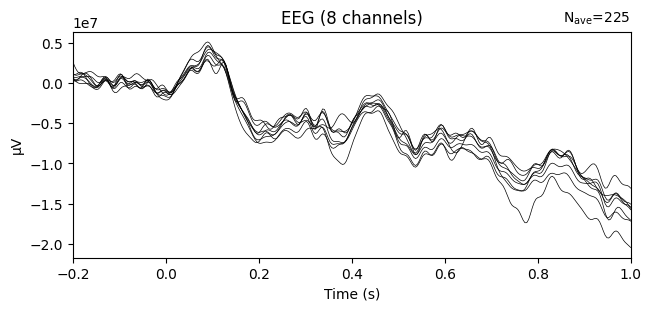

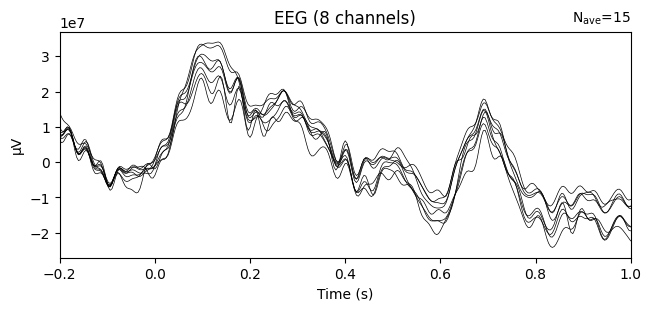

Creating RawArray with float64 data, n_channels=23, n_times=761851
    Range : 0 ... 761850 =      0.000 ...  2987.647 secs
Ready.
Filtering raw data in 1 contiguous segment


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,31,40,46,57,58,223,282,316,327,344,358,374,391,401,415,432,442,453,488,495,503,504) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth:

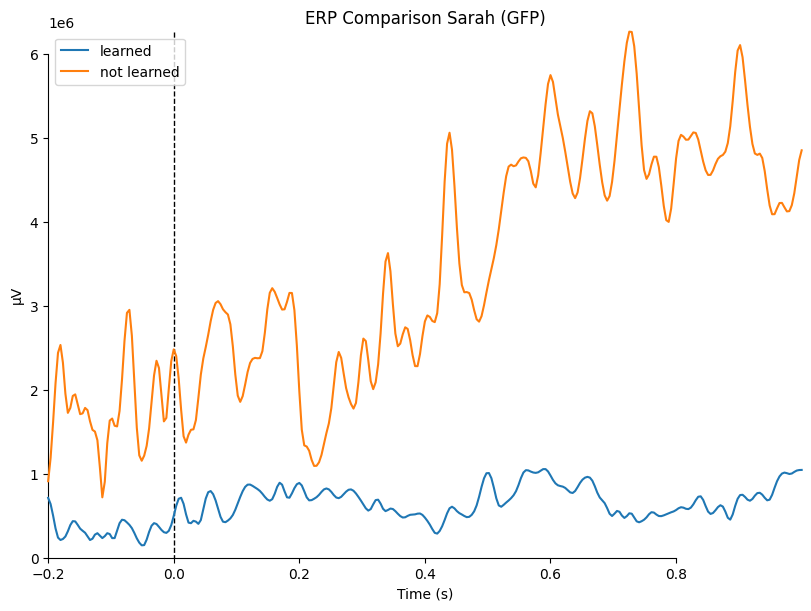

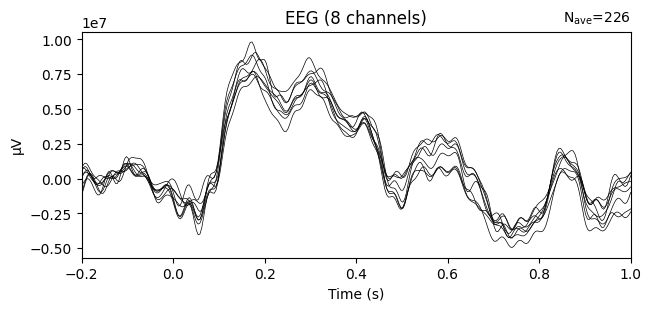

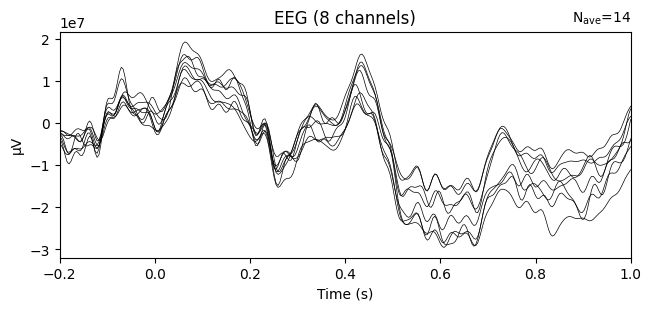

Creating RawArray with float64 data, n_channels=23, n_times=736192
    Range : 0 ... 736191 =      0.000 ...  2887.024 secs
Ready.


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,31,40,46,57,58,223,282,316,327,344,358,374,391,401,415,432,442,453,487,494,502,503) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

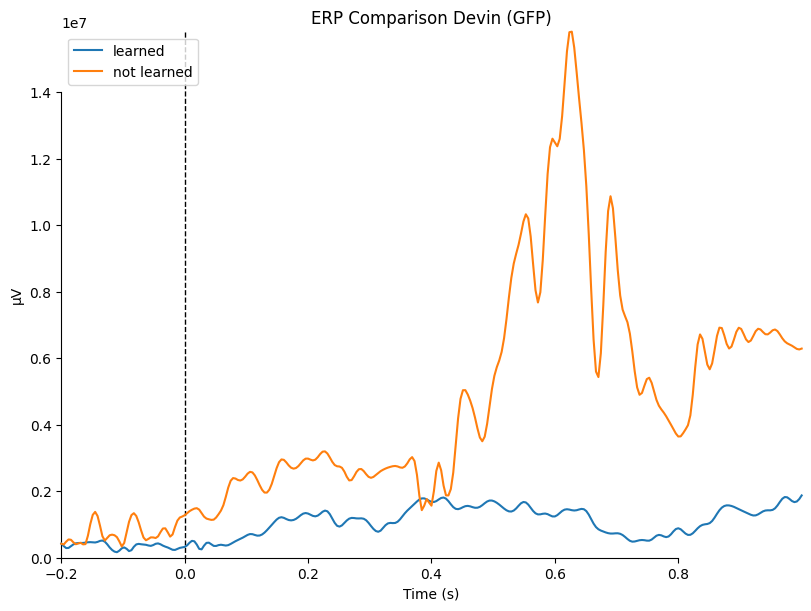

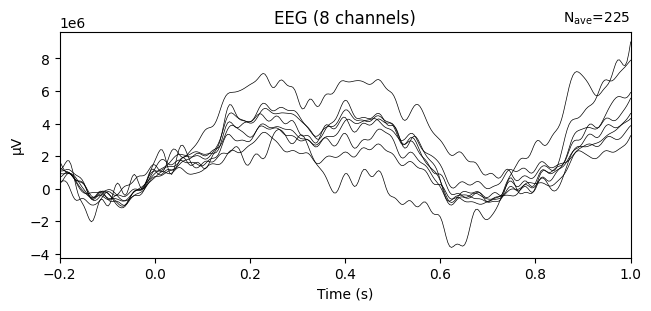

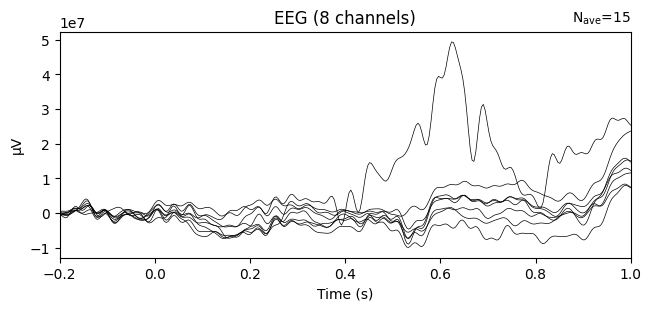

Creating RawArray with float64 data, n_channels=23, n_times=801742
    Range : 0 ... 801741 =      0.000 ...  3144.082 secs
Ready.


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,31,40,46,57,58,223,282,314,325,342,355,371,388,397,413,430,439,453,487,494,502,503,513) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

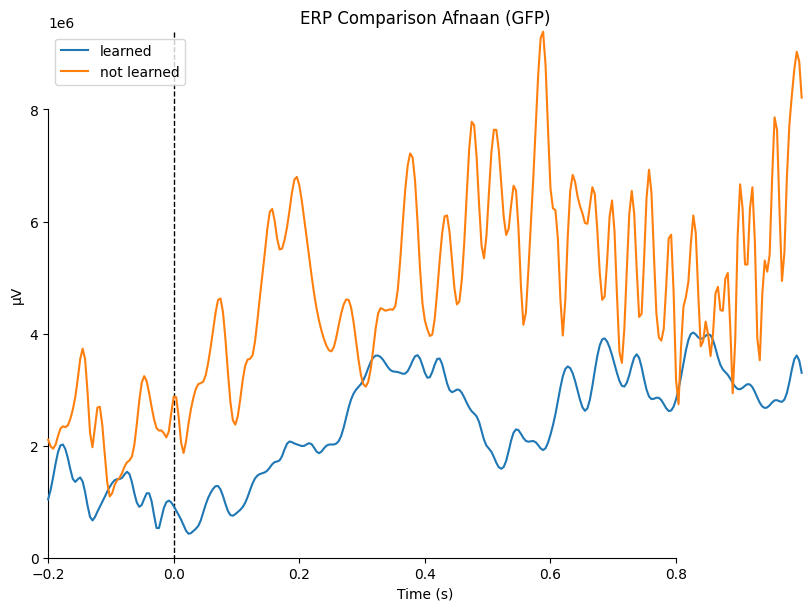

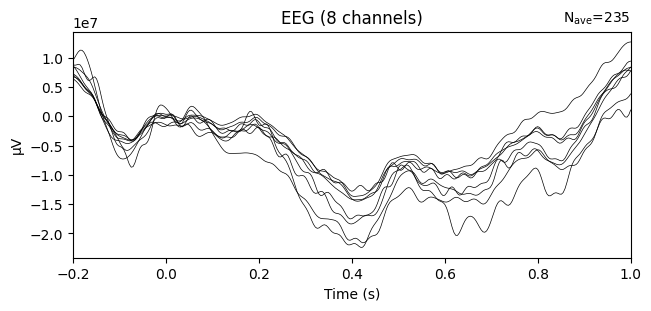

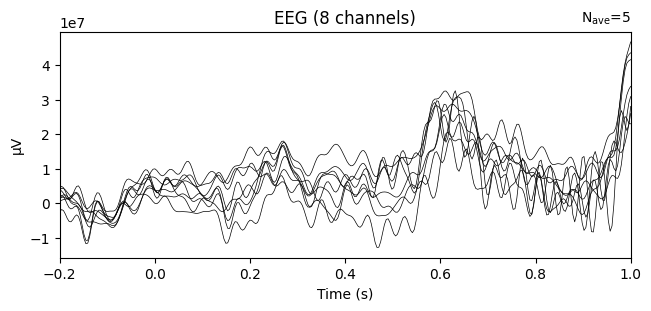

Creating RawArray with float64 data, n_channels=23, n_times=688988
    Range : 0 ... 688987 =      0.000 ...  2701.910 secs
Ready.
Filtering raw data in 1 contiguous segment


C:\Users\cheng\AppData\Local\Temp\ipykernel_32488\2147665343.py:89: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,19,31,40,42,48,50,63,64,229,288,322,333,350,364,380,397,399,409,420,437,439,449,462,498,505,513,514) have mixed types. Specify dtype option on import or set low_memory=False.
  psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth:

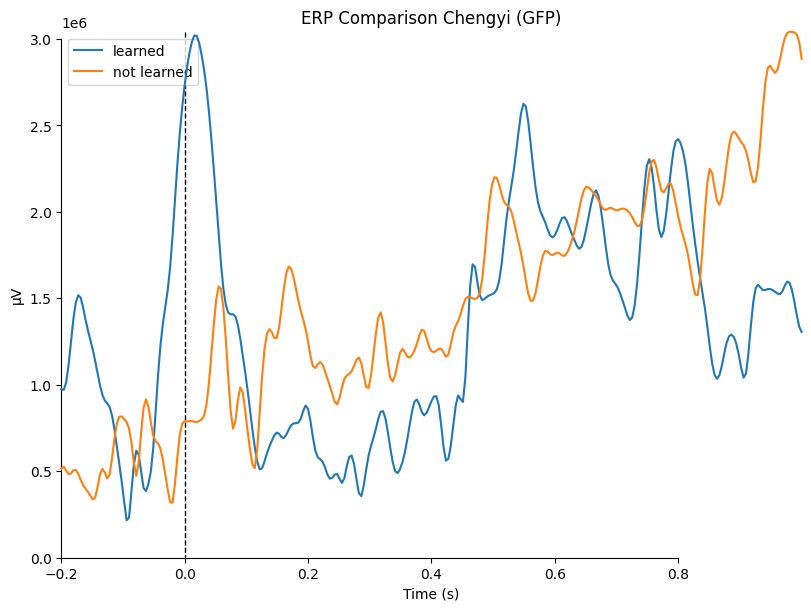

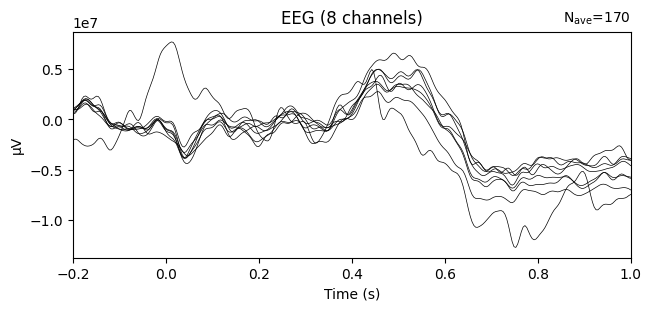

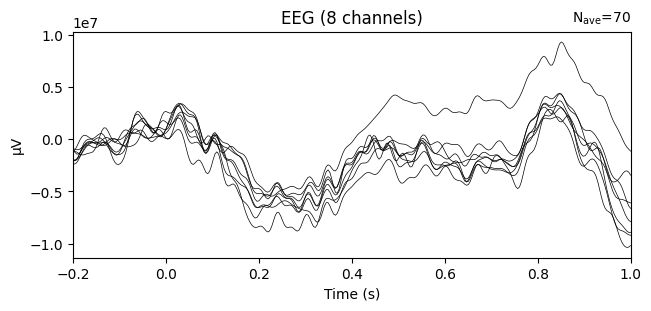

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


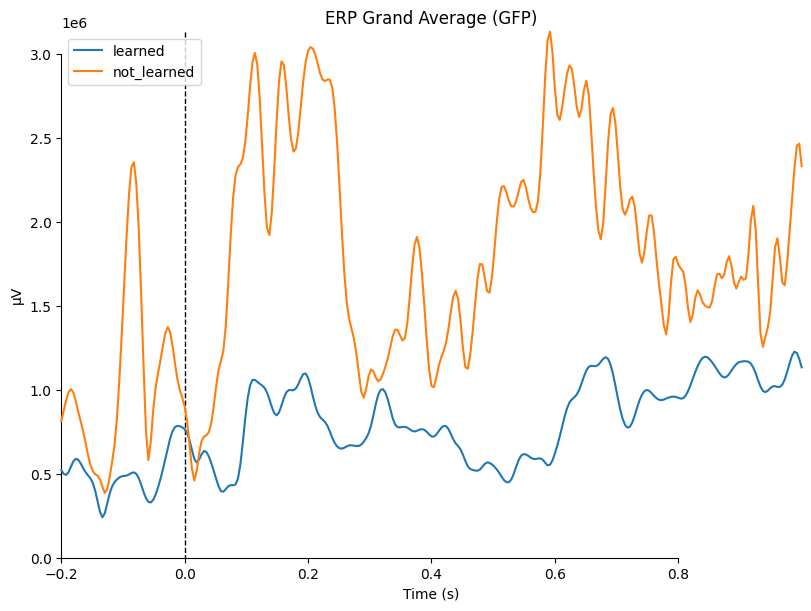

[<Figure size 800x600 with 1 Axes>]

In [3]:
# Install
#!pip install mne
#!pip install pandas
#!pip install numpy

# Import libraries
import mne
import pandas as pd
import numpy as np
from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap
from datetime import datetime, timezone, timedelta
import pytz
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

def ERP_graph(path_EEG_CSV, path_PsychoPy_log, path_PsychoPy_CSV, participantName, consider_certainty=True, certainty_threshold=0.5):
	
	# Helper functions to convert from UNIX time to UTC time
	# UNIX time is saved as an integer (seconds since 1/1/1970)
	# UTC time is saved as a string ("YYYY-MM-DDTHH:MM:SSZ")
	def unix_to_utc(unix_timestamp):
		utc_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)
		local_timezone = pytz.timezone('America/Los_Angeles')
		local_time = utc_time.astimezone(local_timezone) # This gives our UTC time converted to PST
		return utc_time # This gives our raw UTC time
	def utc_to_unix(utc_time_str):
		utc_time = datetime.strptime(utc_time_str, "%Y-%m-%dT%H:%M:%SZ")
		utc_time = utc_time.replace(tzinfo=timezone.utc)
		unix_timestamp = int(utc_time.timestamp())
		return unix_timestamp
	
	# Function to load the data. Simply enter a file path
	def load_eeg_data(file_path):

		# Create a dataframe from our data, replace NAs with 0s
		df = pd.read_csv(file_path, sep='\t', skiprows=2, header=None)
		df.fillna(0.0, inplace=True)

		# Extract EEG data
		trial_data = df.iloc[:, 1:24].values

		# Declares channel names and types of each set of data
		sfreq = 255  # sample rate in Hz
		ch_names = ['Channel {}'.format(i+1) for i in range(trial_data.shape[1])]
		ch_types = ['eeg' for i in range(trial_data.shape[1])]

		# Get the measurement date
		start_time_unix = trial_data[0][21] # This is where EEG start time is stored in UNIX time
		meas_date = unix_to_utc(start_time_unix) # However, MNE takes UTC time

		# Create info structures and RawArray objects for each set of data
		info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
		info.set_meas_date(meas_date)
		raw = mne.io.RawArray(trial_data.T, info)

		# Removing irrelevant channels
		ch_names = [raw.ch_names]
		ch_names_to_keep = [ch_names[0][0:8]]
		raw = raw.pick(ch_names_to_keep[0])

		# Return the RawArray object
		return raw
	
	# Helper function, converts PsychoPy's timestamp into UNIX
	def psychopy_to_unix(psychopy_time):
		
		# Define the format of the input timestamp
		format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

		# Parse the custom timestamp into a datetime object
		parsed_timestamp = datetime.strptime(psychopy_time, format_string)

		# Convert the datetime object to a Unix timestamp (floating-point for microseconds)
		unix_timestamp = parsed_timestamp.timestamp()

		# Print the Unix timestamp
		return unix_timestamp

	# Function to load psychopy data. Simply input the file path
	def load_psychopy_data(file_path):

		# Read psychopy data into a pandas dataframe
		psychopy_df = pd.read_csv(file_path, delimiter=',', skiprows=0, header=0)
		
		#create a new column for the unix time of psychopy stimuli
		psychopy_df = psychopy_df.dropna(subset=["expStart"])
		psychopy_df["expStart"] = psychopy_df["expStart"].astype(str)
		psychopy_df["unix_time"] = psychopy_df["expStart"].apply(psychopy_to_unix)
		
		return psychopy_df
	
	# Function to load log data
	def load_log_data(file_path):
		log_df = pd.read_csv(file_path, sep="\t", header=None, encoding="utf-8")
		log_df = log_df.rename(columns={0: "time", 1: "type", 2: "action"}) # Renames columns for easier access
		return log_df
	
	action_practice_training = ["practice_amharicc: autoDraw = True",
							"amharic_practice2: autoDraw = True"]
	action_practice_testing = ["textAmharic_9: autoDraw = True"]
	action_correctness = ["textCheck: text = '✓'", 
						"textXmark: text = '✗'"]
	action_training = ["amharics1: autoDraw = True", 
						"amharics1_2: autoDraw = True", 
						"amharics2: autoDraw = True", 
						"amharics2_2: autoDraw = True", 
						"amharics3: autoDraw = True", 
						"amharics3_2: autoDraw = True", 
						"amharics4: autoDraw = True", 
						"amharics4_2"]
	action_testing = ["textAmharic_5: autoDraw = True", 
					"textAmharic_6: autoDraw = True", 
					"textAmharic_7: autoDraw = True", 
					"textAmharic_8: autoDraw = True"]
	action_english = ["textOptionA_5: autoDraw = True",
					"textOptionB_5: autoDraw = True",
					"textOptionC_5: autoDraw = True",
					"textOptionD_5: autoDraw = True",
					"textOptionA_6: autoDraw = True",
					"textOptionB_6: autoDraw = True",
					"textOptionC_6: autoDraw = True",
					"textOptionD_6: autoDraw = True",
					"textOptionA_7: autoDraw = True",
					"textOptionB_7: autoDraw = True",
					"textOptionC_7: autoDraw = True",
					"textOptionD_7: autoDraw = True",
					"textOptionA_8: autoDraw = True",
					"textOptionB_8: autoDraw = True",
					"textOptionC_8: autoDraw = True",
					"textOptionD_8: autoDraw = True"]
	action_keypress = ["Keypress: left",
					"Keypress: right",
					"Keypress: up",
					"Keypress: down",
					"Keypress: space"]
	action_diamond = ["textDiamond_8: autoDraw = True", 
					"textDiamond_3: autoDraw = True", 
					"textDiamond_5: autoDraw = True",
					"textDiamond_6: autoDraw = True",
					"textDiamond_7: autoDraw = True",]

	raw = load_eeg_data(path_EEG_CSV)
	psychopy_df = load_psychopy_data(path_PsychoPy_CSV)
	log_df = load_log_data(path_PsychoPy_log)

	filtered_actions = action_testing + action_correctness
	pattern = "|".join(filtered_actions)
	sub_df = log_df[log_df["action"].str.contains(pattern, na=False, regex=True)]
	sub_df.index = range(len(sub_df)) # Renaming row indices for easier iteration

	filtered_certainty = action_keypress + action_diamond + action_practice_testing + action_testing + action_correctness
	certainty_pattern = "|".join(filtered_certainty)
	certainty_df = log_df[log_df["action"].str.contains(certainty_pattern, na=False, regex=True)]
	certainty_df.index = range(len(certainty_df)) # Renaming row indices for easier iteration

	certainty_timestamps = []
	for index in range(len(certainty_df)): # Certainty timestamps
		if ("textAmharic" in certainty_df["action"][index]): 
			certainty = float(certainty_df["time"][index+2] - certainty_df["time"][index+1])
			if certainty < certainty_threshold:
				timestamp, correctness = float(certainty_df["time"][index]), certainty_df["action"][index+3][-2]
				certainty_timestamps.append((timestamp, correctness))
		
	def extract_rows(df, check_symbol, pattern):
		"""
		Extract rows where the 'action' contains 'textAmharic' and the next row's 'action'
		contains the specified check symbol.
		
		Parameters:
			df (pd.DataFrame): The DataFrame containing the data.
			check_symbol (str): The symbol to look for in the next row's action.
			
		Returns:
			learned_list (list): List of rows (as pd.Series) that meet the criteria.
		"""
		list = []
		check_symbol_exists = (check_symbol != "")
		
		# Loop through all rows
		for i in range(len(df)):
			current_action = df.iloc[i]["action"]
			if (check_symbol_exists) and (i < len(df) - 1):
				next_action = df.iloc[i + 1]["action"]
				if str(pattern) in current_action and check_symbol in next_action:
					list.append(df.iloc[i]["time"])
			else:
				if str(pattern) in current_action:
					list.append(df.iloc[i]["time"])
		return list


	learned_list = extract_rows(sub_df, check_symbol="✓", pattern="textAmharic")
	not_learned_list = extract_rows(sub_df, check_symbol="✗", pattern="textAmharic")

	# lists are a bunch of np.float64, convert these all to standard floats
	def np_float_to_float(np_float64_list):
		new_list = []

		for i in range(0,len(np_float64_list)):
			new_list.append(float(np_float64_list[i]))
		
		return new_list


	# now we have lists of just the times
	learned_list_times = np_float_to_float(learned_list)
	not_learned_list_times = np_float_to_float(not_learned_list)
	certainty_list_times = []
	for timestamp, correctness in certainty_timestamps:
		if (correctness == "✓"): 
			certainty_list_times.append(timestamp)

	duration = 1
	if (consider_certainty):
		length = len(certainty_list_times) + len(not_learned_list_times) 
		not_learned_tags = ["not_learned"] * len(not_learned_list_times)
		certainty_tags = ["certainly_learned"] * len(certainty_list_times)
		final_onsets = certainty_list_times + not_learned_list_times
		final_description = certainty_tags + not_learned_tags
	else:
		length = len(learned_list_times) + len(not_learned_list_times)
		not_learned_tags = ["not_learned"] * len(not_learned_list_times)
		learned_tags = ["learned"] * len(learned_list_times)
		final_onsets = learned_list_times + not_learned_list_times
		final_description = learned_tags + not_learned_tags
	duration_list = [duration] * length

	buffer = psychopy_df.loc[0, 'unix_time'] - utc_to_unix(raw.info['meas_date'].strftime("%Y-%m-%dT%H:%M:%SZ"))
	new_orig_time = (raw.info['meas_date'] + timedelta(seconds=buffer)).strftime("%Y-%m-%d %H:%M:%S.%f")

	later_annot = mne.Annotations(
		onset = final_onsets,
		duration = duration_list,
		description = final_description,
		orig_time=new_orig_time,
	)

	raw = raw.copy().set_annotations(later_annot)
	#raw.compute_psd(fmin=0,fmax=50).plot()
	f_low = 0.1
	f_high = 30
	data_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
	#low and high pass filter, fir_design can be changed to match what lit review did

	#notch filter for electrical noise
	data_cleaned.notch_filter(60)
	picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  

	ica = ICA(n_components=8, random_state=97, method="fastica")

	ica.fit(raw)   
	#raw cleaned has been through filtering
	#clean will have gone through ica

	data_cleaned = ica.apply(raw)

	# Extract events from annotations
	events, event_id = mne.events_from_annotations(data_cleaned)

	# Define the epoch time window (start and end in seconds relative to event onset)
	tmin, tmax = -0.2, 1  # for example, 200ms before and 500ms after each event

	#mne expects event ID to be ints and not strings, so we need to change our annotations via dictionary

	# Create epochs
	if (consider_certainty):
		event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"certainly_learned": 1, "not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
		

		# make different epochs for each label
		certainly_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"certainly_learned": 1},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)

		not_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
	else: 
		event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"learned": 1, "not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)
		

		# make different epochs for each label
		learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"learned": 1},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)

		not_learned_event_epochs = mne.Epochs(
			data_cleaned,                # Variable that contains our data
			events,                      # Events we want to investigate, remember we changed T1 and T2 to this
			event_id={"not_learned": 2},
			tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
			tmax=tmax,                   # End time relative to event
			proj=True,                   # Re-references data after everything we've done so far
			picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
			baseline=(None, 0),               # No baseline correction
			preload=True                 # Load the epochs into memory for faster access
		)


	# return for VISUALIZATION
	if (consider_certainty):
		return certainly_learned_event_epochs, not_learned_event_epochs
	else:
		return learned_event_epochs, not_learned_event_epochs


# Store our EEG data path in a variable
#eeg_file_path_csv = '../../../Neurotech 24-25/EEG_data_new/EEG-20250317T232255Z-001/EEG/3_9_2025_JoshIrby_OpenBCI/OpenBCISession_2025-03-09_14-39-02/BrainFlow-RAW_2025-03-09_14-39-02_0.csv'
#psyhcopy_file_path_csv = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.csv'
#log_path = '../../../Neurotech 24-25/psychoPy_data_new/PsychoPy-20250317T232226Z-001/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.log'

JoshuaIrby = {
	"name": "JoshuaIrby",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_9_2025_JoshIrby_OpenBCI/OpenBCISession_2025-03-09_14-39-02/BrainFlow-RAW_2025-03-09_14-39-02_0.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.csv",
    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_9_2025_JoshIrby_PsychoPy/6_finaltest_2025-03-09_14h42.58.498.log"
}

JoshuaWei = {
	"name": "JoshuaWei",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_13_2025_JoshuaWei_OpenBCI/OpenBCISession_2025-03-13_19-40-36/BrainFlow-RAW_2025-03-13_19-40-36_0.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.csv",
    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_JoshuaWei_PsychoPy/42069_finaltest_2025-03-13_20h02.28.660.log"
}

Sarah = {
	"name": "Sarah",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_9_2025_Sarah_OpenBCI/OpenBCISession_2025-03-09_13-24-49/BrainFlow-RAW_2025-03-09_13-24-49_0.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_9_2025_Sarah_PsychoPy/138512_finaltest_2025-03-09_13h31.15.766.csv",
    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_9_2025_Sarah_PsychoPy/138512_finaltest_2025-03-09_13h31.15.766.log"
}

Devin = {
	"name": "Devin",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_11_2025_Devin_OpenBCI/OpenBCISession_2025-03-11_17-07-21/BrainFlow-RAW_2025-03-11_17-07-21_1.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_11_2025_Devin_PsychoPy/devin_finaltest_2025-03-11_17h30.44.028.csv",
    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_11_2025_Devin_PsychoPy/devin_finaltest_2025-03-11_17h30.44.028.log"
}

Afnaan = {
	"name": "Afnaan",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_13_2025_Afnaan_OpenBCI/OpenBCISession_2025-03-13_22-03-16/BrainFlow-RAW_2025-03-13_22-03-16_0.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_Afnaan_PsychoPy/69000_finaltest_2025-03-13_22h43.00.897.csv",
    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_13_2025_Afnaan_PsychoPy/69000_finaltest_2025-03-13_22h43.00.897.log"
}

Chengyi = {
	"name": "Chengyi",
    "eeg": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/EEG/3_12_2025_Chengyi_OpenBCI/OpenBCISession_2025-03-12_17-07-49/BrainFlow-RAW_2025-03-12_17-07-49_1.csv",
    "psychopy_csv": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_12_2025_Chengyi_PsychoPy/69_finaltest_2025-03-12_17h33.18.370.csv",

    "psychopy_log": "C:/Users/cheng/OneDrive/Desktop/Data Collection (OpenBCI & PsychoPy)-20250404T031700Z-001/Data Collection (OpenBCI & PsychoPy)/PsychoPy/3_12_2025_Chengyi_PsychoPy/69_finaltest_2025-03-12_17h33.18.370.log"
}

participants = [JoshuaIrby, JoshuaWei, Sarah, Devin, Afnaan, Chengyi]
learned_evoked_list = []
not_learned_evoked_list = []
for participant in participants:
	
	# For individual graph
	
	learned_event_epochs, not_learned_event_epochs = ERP_graph(participant["eeg"], participant["psychopy_log"], participant["psychopy_csv"], participant["name"], consider_certainty=False) 
	learned_evoked = learned_event_epochs.average()
	not_learned_evoked = not_learned_event_epochs.average()
	evoked_dict = {"learned": learned_evoked, "not learned": not_learned_evoked}
	mne.viz.plot_compare_evokeds(evoked_dict, picks="eeg", title=f"ERP Comparison {participant["name"]}", ci=0.5)
	learned_evoked.plot()
	not_learned_evoked.plot()
	
	# For grand average
	learned_evoked_list.append(learned_event_epochs.average())
	not_learned_evoked_list.append(not_learned_event_epochs.average())
evoked_dict = {"learned": mne.combine_evoked(learned_evoked_list, weights='equal'), "not_learned": mne.combine_evoked(not_learned_evoked_list, weights='equal')}
mne.viz.plot_compare_evokeds(evoked_dict, picks='eeg', title='ERP Grand Average')